# Week 5 Mini Project: Monet Style Image Generation with GAN

By: Jaeyoung Oh

Repo: https://github.com/BlueJayVRStudio/CSCA5642_Week5

## Problem Statement

This week we will using GAN to generate Claude Monet style paintings from real photography. The two sets of photos, real photos (7038) and Monet photos (300), contain images of 256x256 resolution with RGB color channels. Scoring on Kaggle is done using MiFID (Memorization-informed Fréchet Inception Distance), and it will not be implemented separated in this project. We will, however, still evaluate model convergence through loss metrics and also review public Kaggle score.

### Import Modules

In [1]:
import time
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONWARNINGS']='ignore'
import warnings
warnings.filterwarnings("ignore")

import logging
import tensorflow as tf
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow_examples.models.pix2pix.pix2pix import unet_generator, discriminator
from tensorflow.keras.utils import load_img, img_to_array

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

## EDA

In [2]:
def visualize_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image Visualization")
    plt.show()

def visualize_images_from_directory(directory, n_images=5):
    images = os.listdir(directory)
    sample_images = np.random.choice(images, n_images, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path)
        
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        # plt.title(img_name)
    
    plt.tight_layout()
    plt.show()

def analyze_image_properties(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    
    print(f"Image size: {img.size} (width x height)")
    print(f"Image mode: {img.mode}")
    print(f"Array shape: {img_array.shape}")
    
    # display image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    plt.show()
    
    # pixel intensity histogram
    if img_array.ndim == 2 or img_array.shape[2] == 1:
        plt.hist(img_array.ravel(), bins=50, color='gray')
        plt.title("Pixel Intensity Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.show()
    else:
        colors = ['red', 'green', 'blue']
        for i, color in enumerate(colors):
            plt.hist(img_array[:, :, i].ravel(), bins=50, color=color, alpha=0.5, label=f'{color} channel')
        plt.title("Pixel Intensity Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

In [3]:
def clean_path(file):
    return os.path.basename(file)

def clean_ext(file):
    return file[:-4]

Image size: (256, 256) (width x height)
Image mode: RGB
Array shape: (256, 256, 3)


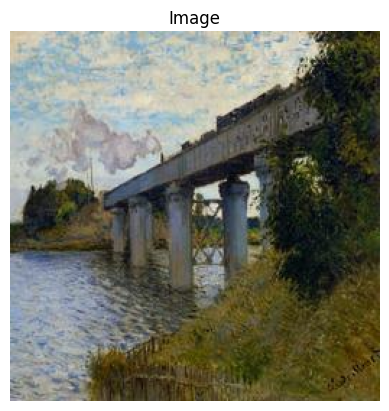

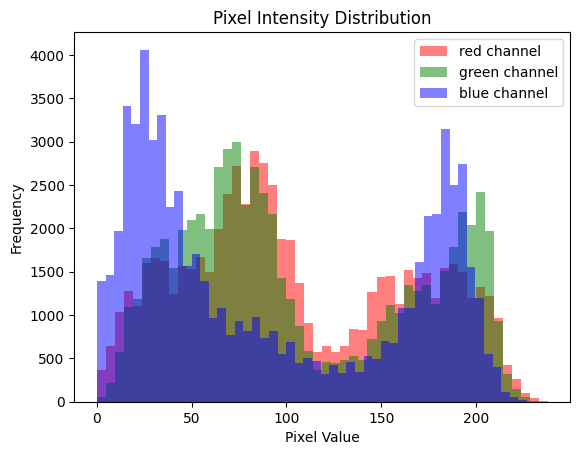

In [4]:
monet_image_path = "./data/monet_jpg/1a127acf4d.jpg"
analyze_image_properties(monet_image_path)

Image size: (256, 256) (width x height)
Image mode: RGB
Array shape: (256, 256, 3)


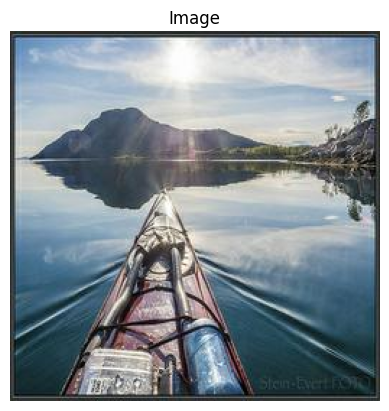

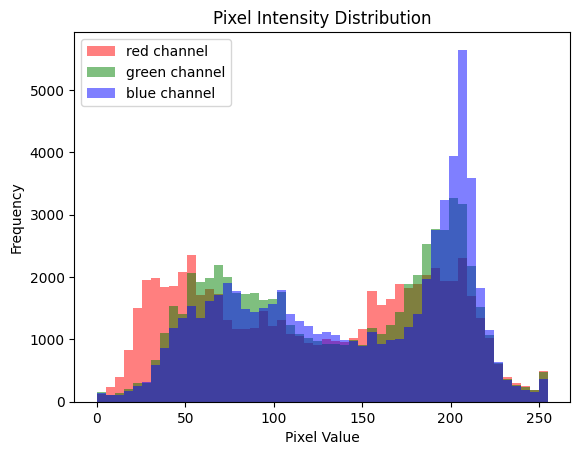

In [5]:
photo_image_path = "./data/photo_jpg/0a8839fac9.jpg"
analyze_image_properties(photo_image_path)

In [6]:
monet_path = './data/monet_jpg/'
photo_path = './data/photo_jpg/'

In [7]:
monet_paths = glob.glob('./data/monet_jpg/*.jpg')

monet_df = pd.DataFrame()

monet_df['file'] = monet_paths
monet_df['file_w_ext'] = monet_paths

monet_df['file'] = monet_df['file'].apply(clean_path).apply(clean_ext)
monet_df['file_w_ext'] = monet_df['file_w_ext'].apply(clean_path)

monet_df['label'] = 1
monet_df

,file,file_w_ext,label
0,000c1e3bff,000c1e3bff.jpg,1
1,011835cfbf,011835cfbf.jpg,1
2,0260d15306,0260d15306.jpg,1
3,049e293b93,049e293b93.jpg,1
4,05144e306f,05144e306f.jpg,1
...,...,...,...
295,fba982625d,fba982625d.jpg,1
296,fc11d52502,fc11d52502.jpg,1
297,fd63a333f1,fd63a333f1.jpg,1
298,fdf1530d95,fdf1530d95.jpg,1


In [8]:
photo_paths = glob.glob('./data/photo_jpg/*.jpg')

photo_df = pd.DataFrame()

photo_df['file'] = photo_paths
photo_df['file_w_ext'] = photo_paths

photo_df['file'] = photo_df['file'].apply(clean_path).apply(clean_ext)
photo_df['file_w_ext'] = photo_df['file_w_ext'].apply(clean_path)

photo_df['label'] = 1
photo_df

,file,file_w_ext,label
0,00068bc07f,00068bc07f.jpg,1
1,000910d219,000910d219.jpg,1
2,000ded5c41,000ded5c41.jpg,1
3,00104fd531,00104fd531.jpg,1
4,001158d595,001158d595.jpg,1
...,...,...,...
7033,ffd71fce61,ffd71fce61.jpg,1
7034,ffe1af8ca0,ffe1af8ca0.jpg,1
7035,fff5c33050,fff5c33050.jpg,1
7036,fffaaaae65,fffaaaae65.jpg,1


In [9]:
# paths to datasets
photo_dir = "./data/photo_jpg"
monet_dir = "./data/monet_jpg"

# create a list of file paths
photo_paths = [os.path.join(photo_dir, fname) for fname in os.listdir(photo_dir)]
monet_paths = [os.path.join(monet_dir, fname) for fname in os.listdir(monet_dir)]

# define a preprocessing function
def preprocess_image(file_path):
    image = tf.io.read_file(file_path)  # Read the image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG
    image = tf.image.resize(image, [256, 256])  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    return image

# create tf.data.Dataset for each set
photo_dataset = tf.data.Dataset.from_tensor_slices(photo_paths)
monet_dataset = tf.data.Dataset.from_tensor_slices(monet_paths)

# apply preprocessing
photo_dataset = photo_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
monet_dataset = monet_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# batch and prefetch the datasets
photo_dataset = photo_dataset.batch(4).prefetch(tf.data.AUTOTUNE)
monet_dataset = monet_dataset.batch(4).prefetch(tf.data.AUTOTUNE).repeat()

combined_dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset))

I0000 00:00:1733153436.628635  966365 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733153438.694778  966365 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733153438.694836  966365 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733153438.696923  966365 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733153438.697014  966365 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [10]:
len(photo_dataset)

1760

In [11]:
len(combined_dataset)

1760

In [12]:
# for photo_batch, monet_batch in combined_dataset.take(2):
#     # select the first image from each batch
#     photo_image = photo_batch[0].numpy()
#     monet_image = monet_batch[0].numpy()

#     # visualize the photo and Monet image
#     plt.figure(figsize=(10, 5))

#     # display the photo
#     plt.subplot(1, 2, 1)
#     plt.title("Photo Image")
#     plt.imshow(photo_image)
#     plt.axis("off")

#     # display the Monet image
#     plt.subplot(1, 2, 2)
#     plt.title("Monet Image")
#     plt.imshow(monet_image)
#     plt.axis("off")

#     plt.show()

## CycleGAN

Reference: https://www.tensorflow.org/tutorials/generative/cyclegan

In [13]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss



In [14]:
class CycleGAN_Model(tf.keras.Model):
    def __init__(self, gen_g, gen_f, disc_x, disc_y):
        super(CycleGAN_Model, self).__init__()
        self.generator_g = gen_g
        self.generator_f = gen_f
        self.discriminator_x = disc_x
        self.discriminator_y = disc_y

    def compile(self, generator_g_optimizer, generator_f_optimizer, discriminator_x_optimizer, discriminator_y_optimizer):
        super(CycleGAN_Model, self).compile()
        self.generator_g_optimizer = generator_g_optimizer
        self.generator_f_optimizer = generator_f_optimizer
        
        self.discriminator_x_optimizer = discriminator_x_optimizer
        self.discriminator_y_optimizer = discriminator_y_optimizer

    def train_step(self, train_generator):
        # persistent is set to True because the tape is used more than
        # once to calculate the gradients.

        real_x, real_y = train_generator
        
        with tf.GradientTape(persistent=True) as tape:
            # Generator G translates X -> Y
            # Generator F translates Y -> X.
            # X: Real
            # Y: Monet
            
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)
            
            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)
            
            # same_x and same_y are used for identity loss.
            same_x = self.generator_f(real_x, training=True)
            same_y = self.generator_g(real_y, training=True)
            
            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)
            
            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)
            
            # calculate the loss
            gen_g_loss = generator_loss(disc_fake_y)
            gen_f_loss = generator_loss(disc_fake_x)
            
            total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
            
            # Total generator loss = adversarial loss + cycle loss
            total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
            total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
            
            disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
            disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
            
        # Calculate the gradients for generator and discriminator
        generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                            self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                            self.generator_f.trainable_variables)
        
        discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                                self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                                self.discriminator_y.trainable_variables)
        
        # Apply the gradients to the optimizer
        self.generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                                self.generator_g.trainable_variables))
        
        self.generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                                self.generator_f.trainable_variables))
        
        self.discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                    self.discriminator_x.trainable_variables))
        
        self.discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                    self.discriminator_y.trainable_variables))

        return {
            "gen_monet_loss": total_gen_g_loss,
            "gen_real_loss": total_gen_f_loss,
            "disc_monet_loss": disc_y_loss,
            "disc_real_loss": disc_x_loss,
        }

In [25]:
OUTPUT_CHANNELS=3

# instantiate unet generators and discriminators
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

In [26]:
# generator.summary()

In [27]:
# compile the model
model = CycleGAN_Model(generator_g, generator_f, discriminator_x, discriminator_y)

In [28]:
model.summary()

Model: "cycle_gan__model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_55 (Functional)      │ (None, None, None, 3)  │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_71 (Functional)      │ (None, None, None, 3)  │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_75 (Functional)      │ (None, None, None, 1)  │     2,765,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_79 (Functional)      │ (None, None, None, 1)  │     2,765,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,361,096 (436.25 MB)

 Trainable params: 114,361,096 (436.25 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# train the model
# history = model.fit(combined_dataset_inv, steps_per_epoch=75, epochs=5)
# history = model.fit(combined_dataset_inv, epochs=1)

model.compile(
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
)

In [30]:
# history = model.fit(combined_dataset, steps_per_epoch=50, epochs=50)
history = model.fit(combined_dataset, epochs=3)

Epoch 1/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 349s 150ms/step - disc_monet_loss: 0.6827 - disc_real_loss: 0.6628 - gen_monet_loss: 2.4266 - gen_real_loss: 2.4829
Epoch 2/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 207s 118ms/step - disc_monet_loss: 0.6760 - disc_real_loss: 0.6513 - gen_monet_loss: 1.8659 - gen_real_loss: 1.9305
Epoch 3/5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 212s 120ms/step - disc_monet_loss: 0.6666 - disc_real_loss: 0.6553 - gen_monet_loss: 1.7543 - gen_real_loss: 1.7864
Epoch 4/5
 563/1760 ━━━━━━━━━━━━━━━━━━━━ 2:21 118ms/step - disc_monet_loss: 0.5549 - disc_real_loss: 0.6531 - gen_monet_loss: 2.1709 - gen_real_loss: 1.7713


KeyboardInterrupt



In [51]:
generator_g.save('./models/generator_g.keras')
generator_g.save_weights('./models/generator_g.weights.h5')
# discriminator.save('./models/discriminator.keras')

In [ ]:
# model.save('./models/model.keras')

In [31]:
# load and preprocess the input image
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# post-process the generated image
def postprocess_image(image_array):
    image_array = np.squeeze(image_array, axis=0)
    image_array = (image_array * 255).astype(np.uint8)
    return image_array

# predict a stylized image
def predict_image(image_path, _generator):
    input_image = preprocess_image(image_path)
    generated_image = _generator(input_image)
    return postprocess_image(generated_image)

# visualize the input and output
def visualize_predictions(image_dir, _generator, num_images=10):
    # get all image paths from the directory
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    
    # randomly sample 10 images
    random_paths = random.sample(image_paths, num_images)
    
    # visualize predictions
    plt.figure(figsize=(15, num_images * 2.5))
    for i, image_path in enumerate(random_paths):
        # predict the stylized image
        generated_image = predict_image(image_path, _generator)
        # generated_image = np.expand_dims(generated_image, axis=0)
        # print(generated_image)
        
        # load the input image for visualization
        input_image = load_img(image_path, target_size=(256, 256))

        # display the input image
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.title(f"Input Image {i + 1}")
        plt.imshow(input_image)
        plt.axis("off")

        # display the stylized image
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.title(f"Stylized Image {i + 1}")
        plt.imshow(generated_image)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

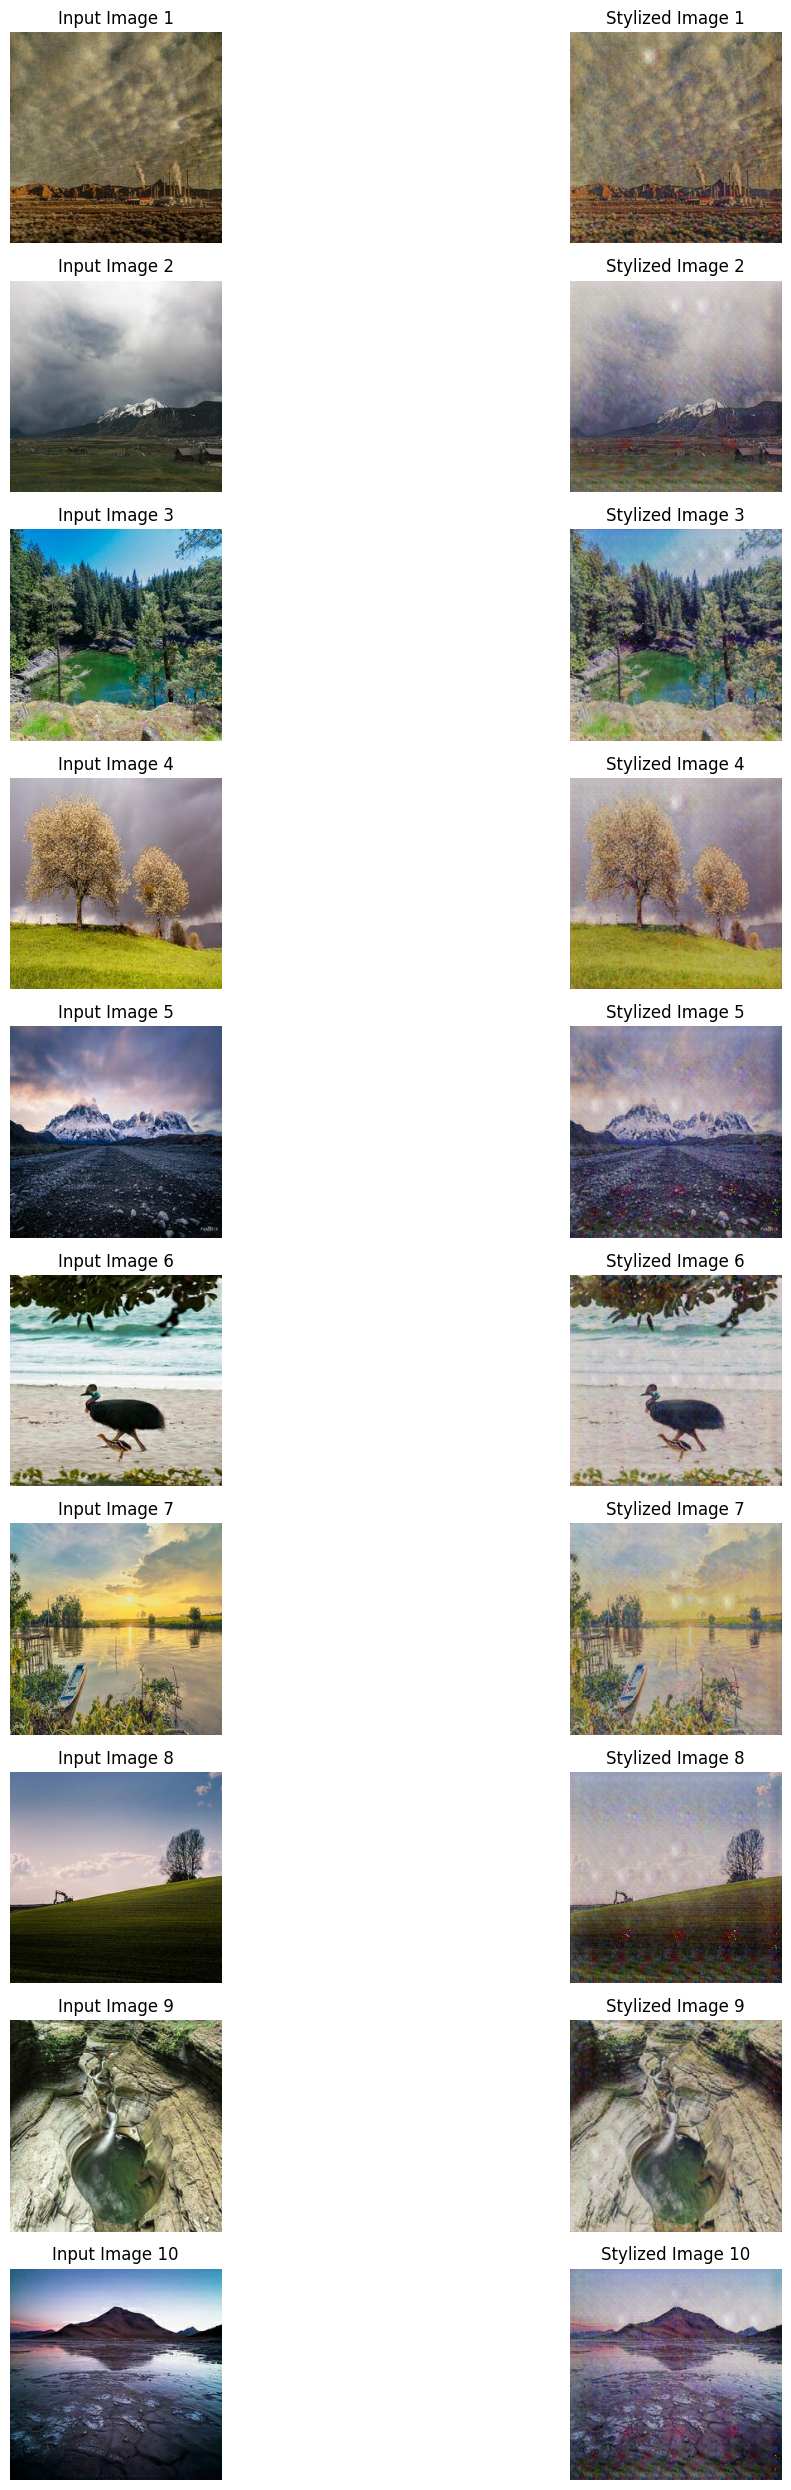

In [53]:
visualize_predictions("./data/photo_jpg", generator_g)

In [33]:
# # model = load_model('./models/model.keras')
# generator = load_model('./models/generator.keras')
# discriminator = load_model('./models/discriminator.keras')

In [41]:
for photo_path in photo_paths[:10]:
    generated_image = predict_image(photo_path, generator_g)
    tf.keras.utils.save_img(f'./submissions/cyclegan/{os.path.basename(photo_path)}', generated_image)

In [ ]:
import shutil
shutil.make_archive("./submissions/cyclegan_images", "zip", "./submissions/cyclegan")